In [3]:
#@title <b><font color="red">▶</font><font color="black"> run this cell to prepare supplementary materials for the lesson</font></b>

!rm -rf harbour-space-text-mining-course
!git clone https://github.com/horoshenkih/harbour-space-text-mining-course.git
import sys
sys.path.append('harbour-space-text-mining-course')

from tmcourse.ipyquiz import Quiz

from tmcourse.utils import (
    enable_mathjax_in_cell,
    plot_confusion_matrix,
    show_vectorizer_largest_components,
)
from tmcourse.quiz import (
    quiz_kmeans,
    quiz_estimate_clustering_quality,
    quiz_nmf,
    quiz_coherence,
)
from tmcourse.demo import (
    demo_kmeans,
)

from tqdm.notebook import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
import numpy as np


Cloning into 'harbour-space-text-mining-course'...
remote: Enumerating objects: 222, done.
remote: Counting objects: 100% (222/222), done.
remote: Compressing objects: 100% (162/162), done.
remote: Total 529 (delta 122), reused 159 (delta 59), pack-reused 307
Receiving objects: 100% (529/529), 46.20 MiB | 17.65 MiB/s, done.
Resolving deltas: 100% (305/305), done.
Checking out files: 100% (68/68), done.


<!--@slideshow slide-->
<center><h1>Topic Modeling</h1></center>

<!--@slideshow slide-->
# Last lesson's review
1. Machine Learning basics
  - Data + Answers $\rightarrow$ Rules (Model)
  - Rules predict answers on **new similar** objects
  - Linear models
  - Loss function
  - Gradient descent
  - Overfitting
  - Cross-validation
2. Text classification
  - `TfidfVectorizer`
  - `Pipeline`
  - Important tokens

<!--@slideshow slide-->
# Plan for today
1. Motivation: automatically find groups of related documents
1. Clustering. $k$-means algorithm.
1. Clustering of TF-IDF vectors. Topics.
1. **Coding session 1**: $k$-means.
1. Non-negative matrix factorization (NMF).
1. **Coding session 2**: NMF.
1. Probability refresher: total probability, conditional independency.
1. Version of NMF: Probabilistic Latent Semantic Allocation (PLSA).
1. PLSA algorithm.
1. Latent Dirichlet Allocation (LDA): "smooth" version of PLSA.
1. Python libraries: gensim, pyLDAvis
1. Evaluate quality of topics.
1. Apply LDA model.
1. **Coding session 3**: LDA.

<!--@slideshow slide-->
# Motivation

- We know how to solve text classification problem using Machine Learning.
- But what if we don't know the labels?
- Can we somehow extract labels from the data?

<!--@slideshow slide-->
# Clustering

<!--@slideshow slide-->
How many classes are on the picture?

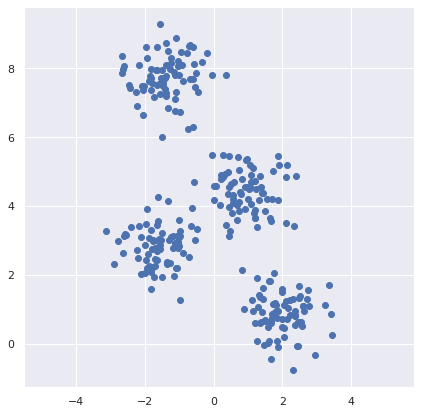

In [0]:
#@slideshow fragment tags=remove_input
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=300, centers=4, random_state=0, cluster_std=0.6)
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 7))
plt.axis("equal")
plt.scatter(X[:, 0], X[:, 1])
plt.show()

<!--@slideshow fragment-->
Can we find them automatically?

<!--@slideshow slide-->
# $k$-means algorithm

$k$-means algorithm computes $k$ cluster centers using so-called **expectation-minimization** approach.

1. Start with initial (random) cluster centers.
2. Update cluster centers, repeating 2 steps:
    1. Assign points to the nearest cluster center (**expectation** step).
    2. Set the centers to the average of points belongint to the cluster (**maximization** step).

<!--@slideshow slide-->
## Colab demo: $k$-means

In [0]:
demo_kmeans(k=4)

In [0]:
# try wrong number of cluster
demo_kmeans(k=5)

<!--@slideshow slide-->
## Colab quiz 1
One step of $k$-means algorithm

In [0]:
enable_mathjax_in_cell()
quiz_kmeans()()

<!--@slideshow slide-->
Since we know true labels of texts, **in this lesson** we will evaluate quality of clustering using true labels.



In [0]:
#@slideshow fragment
def estimate_clustering_quality(target, prediction):
    from itertools import combinations
    N = len(target)
    total_pairs = 0
    # we will count the ratio of "good" pairs of points
    good_pairs = 0
    for pair in combinations(range(N), 2):
        # NB: O(n**2) complexity!
        total_pairs += 1
        i, j = pair
        if (target[i] == target[j]) == (prediction[i] == prediction[j]):
            # a pair of points is "good" if and only if
            #   - both points belong to the same cluster and have the same label
            #   - or points belong to different clusters and have different labels
            good_pairs += 1

    return good_pairs / total_pairs

<!--@slideshow slide-->
## Colab quiz 2

Evaluate quality of clustering.

In [0]:
enable_mathjax_in_cell()
quiz_estimate_clustering_quality()()

<!--@slideshow slide-->
# Clustering of TF-IDF vectors. Topics.

Now we kknow how
- Find clusters of vectors
- Extract vectors from texts

So we can find clusters of texts using `sklearn.cluster.KMeans`.

<!--@slideshow slide-->
## Colab demo: $k$-means in `sklearn`

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
import numpy as np

categories = ("sci.space", "rec.sport.hockey", "comp.graphics")
fetch_params = dict(
    shuffle=True, random_state=1,
    remove=('headers', 'footers', 'quotes'),
    categories=categories
)
train_dataset = fetch_20newsgroups(subset="train", **fetch_params)
test_dataset = fetch_20newsgroups(subset="test", **fetch_params)

vec = TfidfVectorizer(stop_words="english")
vec.fit(train_dataset.data)
X_train = vec.transform(train_dataset.data)
X_test = vec.transform(test_dataset.data)

In [0]:
# for this dataset we know the true number of classes, but in general we don't
n_clusters = len(categories)

0.7146142174961424

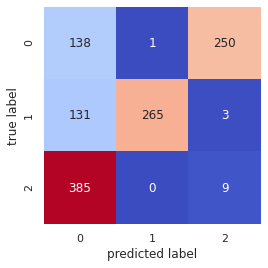

In [0]:
# KMeans has standard fit/predict interface
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=20)
kmeans.fit(X_train)  # takes vectors
predictions = kmeans.predict(X_test)  # returns clusters
plot_confusion_matrix(test_dataset.target, predictions)
estimate_clustering_quality(test_dataset.target, predictions)

Compare clustering quality with random benchmark.

0.5557895671883216

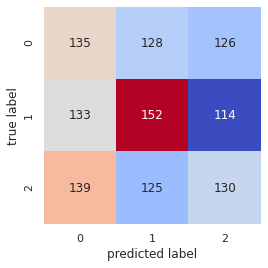

In [0]:
import random
random.seed(0)
random_predictions = [random.randint(0, n_clusters - 1) for _ in test_dataset.target]
plot_confusion_matrix(test_dataset.target, random_predictions)
estimate_clustering_quality(test_dataset.target, random_predictions)

Compare with classification.


0.8967120410446853

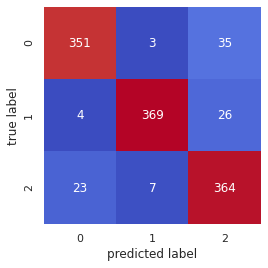

In [0]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(alpha=.0001, max_iter=50, penalty="l2", loss="log", random_state=0)
clf.fit(X_train, train_dataset.target)
plot_confusion_matrix(test_dataset.target, clf.predict(X_test))
estimate_clustering_quality(test_dataset.target, clf.predict(X_test))

<!--@slideshow slide-->
Let's do an experiment.

What are the largest components (words) for each centroid?

In [0]:
#@slideshow fragment tags=remove_input
show_vectorizer_largest_components(vec, kmeans.cluster_centers_)

['use', 'new', 'year', 'long', 'good', 'does', 'edu', 'earth', 'moon', 'orbit',
 'launch', 'time', 'know', 'people', 'nasa', 'think', 'don', 'like', 'just',
 'space']
['player', 'toronto', 'good', 'leafs', 'espn', 'playoffs', 'teams', 'win',
 'think', 'detroit', 'league', 'year', 'nhl', 'games', 'season', 'players',
 'play', 'hockey', 'team', 'game']
['color', 'code', 'use', 'mail', 'advance', 'ftp', 'hi', 'format', 'help',
 'need', 'windows', 'looking', 'does', 'program', 'image', 'know', 'file',
 'files', 'graphics', 'thanks']


<!--@slideshow fragment-->
Is there the correspondence between largest components and true categories? Remember that the categories are ("sci.space", "rec.sport.hockey", "comp.graphics").


<!--@slideshow fragment-->
It is important that we found centroids (and their components) **without any information about true categories**.

We somehow "inferred" categories. Let's call them _topics_.

<!--@slideshow slide-->
# Coding session 1

Apply $k$-means on tf-idf vectors of the dataset `harbour-space-text-mining-course/datasets/content_classification.csv`.
The dataset has 7 categories: leisure, affection, bonding, enjoy_the_moment, achievement, nature, exercise. Can you find the cluster that corresponds to the category "achievement"?

**Hints**:
- Use parameters `n_clusters=7`, `n_init=10`, `max_iter=10`, `random_state=0` for `KMeans`
- Use the function `show_vectorizer_largest_components` to see the words corresponding to the largest components.

In [0]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv("harbour-space-text-mining-course/datasets/content_classification.csv", header=0, names=["text", "label"])

# YOUR CODE HERE
# print(df.head())
le = LabelEncoder()
y = le.fit_transform(df.label)
# print(df.head())

X_train, X_test, y_train, y_test = train_test_split(df.text, y, test_size=0.25, random_state=42, shuffle=True)
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

trf = TfidfVectorizer(stop_words="english")
trf.fit(X_train)
X_train = trf.transform(X_train)
X_test = trf.transform(X_test)
# print(X_train.shape, X_test.shape)

0.623916633983308

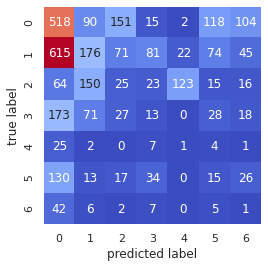

In [0]:
kmeans = KMeans(n_clusters=7, n_init=10, max_iter=10, random_state=42)
kmeans.fit(X_train)
predictions = kmeans.predict(X_test)
plot_confusion_matrix(y_test, predictions)
estimate_clustering_quality(y_test, predictions)

<!--@slideshow slide-->
# Non-negative matrix factorization (NMF)

<!--@slideshow fragment-->
So, we accidentally discovered topics. Now let's try to formalize this discovery.

<!--@slideshow slide-->
**Q**: Can a document have many topics?


<!--@slideshow fragment-->
**A**: Why not?
> Systems as diverse as genetic networks or the world wide web are best described as
networks with complex topology. A common property of many large networks is that the
vertex connectivities follow a scale-free power-law distribution.


<!--@slideshow slide-->
**Q**: Can a word represent many topics?


<!--@slideshow fragment-->
**A**: Sure! https://en.wikipedia.org/wiki/Matrix


<!--@slideshow slide-->
So in general we cannot assign one topic to a document or to a word. A document or a word may have all possible topics in some (probably small) proportions.


<!--@slideshow fragment-->
More formally:
- Suppose we want to find $T$ topics
- For each document and for each word, assign a non-negative vector with $T$ elements.
- The larger the $i$-th component, the higher the affinity of the document/word with the $i$-th topic.


<!--@slideshow fragment-->
**Q**: How to find such vectors?


<!--@slideshow fragment-->
**A**: Since we have a tfidf-matrix, let's try to extract topics from it. By the way, there is a suitable matrix method.

<!--@slideshow slide-->
What we want:

![alt text](https://raw.githubusercontent.com/horoshenkih/harbour-space-text-mining-course/master/pic/doc-topic-term-topic.png)

<!--@slideshow slide-->
What we have:

![doc-term](https://raw.githubusercontent.com/horoshenkih/harbour-space-text-mining-course/master/pic/doc-term.png)

<!--@slideshow slide-->
What we will try:

![alt text](https://raw.githubusercontent.com/horoshenkih/harbour-space-text-mining-course/master/pic/product.png)

<!--@slideshow fragment-->
**Definition**: non-negative matrix factorization of the matrix $X$ is a pair of matrices $D, W$ such that $X \approx D \cdot W$.

<!--@slideshow slide-->
##  Non-negative number factorization

We will examine the simplest version of non-negative matrix factorization $X \approx D\cdot W$, where $X, D, W$ are just numbers ($1 \times 1$ matrices).
<!--@slideshow fragment-->
The algorithm of factorization is called ALS (Alternating Least Squares). The idea is to minimize the difference between $X$ and $D \cdot W$:
$$
L_X(D, W) = \frac{1}{2}(X - D\cdot W)^2
$$
<!--@slideshow fragment-->
The function $L_X$ depends on variables $D, W$, and we need to minimize $L_X$.

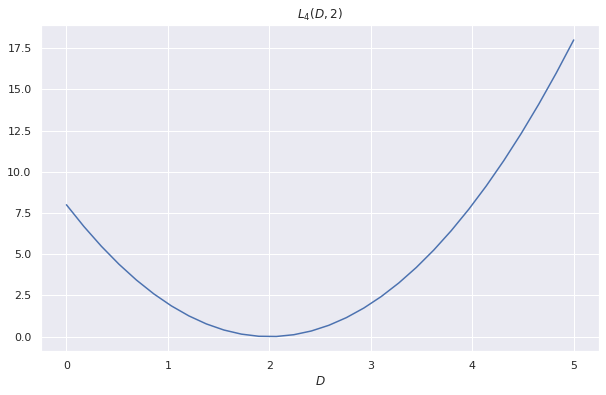

In [0]:
#@slideshow slide tags=remove_input
# this is how L_X(D, W) depends on D for fixed X and W

X = 4
def L_X(D, W):
    return 0.5 * (X - D*W)**2

D_range = np.linspace(0, 5, 30)
plt.figure(figsize=(10, 6))
plt.plot(D_range, L_X(D_range, 2))
plt.xlabel(r"$D$")
plt.title(r"$L_4(D, 2)$")
plt.show()

<!--@slideshow slide-->
Suppose some $W_0$ is fixed. Then $L_X(D, W_0)$ depends only on $D$. Denote this function $f(D) \equiv L_X(W_0, D)$.
We can compute the derivative:
$$
\dfrac{\mathrm{d}f}{\mathrm{d}D} = (D\cdot W - X) \cdot W
$$

<!--@slideshow fragment-->
Recall the interpretation of the derivative: if we change $D$ by some small amount $\Delta D$, then the function $f(D)$ will change by $\Delta f(D) \approx \dfrac{\mathrm{d}f}{\mathrm{d}D} \Delta D$.


<!--@slideshow slide-->
Our goal is to minimize the function $f$. Since we know the derivative $\dfrac{\mathrm{d}f}{\mathrm{d}D}$, we can take a small step $\Delta D$ such that $\Delta f(D) < 0$ and decrease $f$ a little.
- If $\dfrac{\mathrm{d}f}{\mathrm{d}D} > 0$, take step $\Delta D < 0$
- If $\dfrac{\mathrm{d}f}{\mathrm{d}D} < 0$, take step $\Delta D > 0$

In both cases, we take the step in the direction opposite to $\dfrac{\mathrm{d}f}{\mathrm{d}D}$.


<!--@slideshow fragment-->
Clearly, we can do the same thing with $W$, having $D$ fixed.


<!--@slideshow slide-->
So this ALS (Alternating least squares):
0. Choose _learning rate_ $\lambda$ (some positive small number).
1. Initialize $D^{(0)}$, $W^{(0)}$ randomly.
2. Repeat for $t = 0, 1, 2, \dots$ until convergence:
    1. Change $D$ by $\Delta D$:
    $$D^{(t+1)} = D^{(t)} - \lambda \cdot (D^{(t)}W^{(t)} - X) W^{(t)}$$
    2. Change $W$ by $\Delta W$:
    $$W^{(t+1)} = W^{(t)} - \lambda \cdot (D^{\color{red}{(t+1)}}W^{(t)} - X) D^{\color{red}{(t+1)}}$$

In [0]:
#@slideshow
def non_negative_number_factorization(
    X,  # number to factorize
    D0=None,  # optional initial value for D
    W0=None,  # optional initial value for W
    tolerance=1e-4,  # stop iterations if |X - WD| < tolerance
    learning_rate=1e-5,  # lambda in the formula
    seed=0,
):
    import numpy as np
    # initialize W and D with W0, D0 or randomly
    np.random.seed(seed)
    D = D0 or np.random.random() * X  # random from 0 to X
    W = W0 or np.random.random() * X  # random from 0 to X

    # repeat alternating steps until convergence
    while np.abs(X - D*W) > tolerance:
        D_step = -learning_rate * (W*D - X) * W
        D += D_step
        assert D > 0
        W_step = -learning_rate * (W*D - X) * D
        W += W_step
        assert W > 0
    return D, W

In [0]:
#@slideshow fragment
# factorize X = 4
D, W = non_negative_number_factorization(4)
print(D, W, D*W)

1.630045471770632 2.453980621551367 4.0000999999726865


<!--@slideshow slide-->
## Colab demo: NMF in sklearn

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
trf = TfidfVectorizer(stop_words="english")
trf.fit(train_dataset.data)
X_train = trf.transform(train_dataset.data)
X_test = trf.transform(test_dataset.data)

In [0]:
# NMF has standatd fit/transform interface
from sklearn.decomposition import NMF
nmf = NMF(
    n_components=3,
    random_state=0,
    solver="cd",  # coordinate descent == ALS
    init="random"
)
nmf.fit(X_train)
X_train_nmf = nmf.transform(X_train)

# to transform the new input data, factorize the input matrix with fixed self.components_
X_test_nmf = nmf.transform(X_test)

In [0]:
show_vectorizer_largest_components(trf, nmf.components_)

['research', 'mission', 'think', 'satellite', 'sci', 'gov', 'cost', 'like',
 'people', 'data', 'station', 'just', 'lunar', 'earth', 'orbit', 'moon',
 'shuttle', 'launch', 'nasa', 'space']
['code', 'hi', 'mail', 'use', 'advance', 'ftp', 'format', 'software', 'looking',
 'help', 'windows', 'need', 'does', 'program', 'file', 'know', 'image', 'files',
 'thanks', 'graphics']
['toronto', 'time', 'good', 'like', 'just', 'win', 'teams', 'detroit', 'league',
 'don', 'think', 'year', 'nhl', 'season', 'players', 'games', 'play', 'hockey',
 'team', 'game']


0.8544065584386744

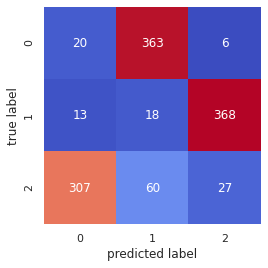

In [0]:
dominant_topics = np.argmax(X_test_nmf, axis=1)

plot_confusion_matrix(test_dataset.target, dominant_topics)
estimate_clustering_quality(test_dataset.target, dominant_topics)

<!--@slideshow slide-->
## Colab quiz 3

Choose the correct NMF

In [0]:
enable_mathjax_in_cell()
quiz_nmf()()

<!--@slideshow slide-->
# Coding session 2

Apply `NMF` on tf-idf vectors of the dataset `harbour-space-text-mining-course/datasets/content_classification.csv`.
The dataset has 7 categories: leisure, affection, bonding, enjoy_the_moment, achievement, nature, exercise. Can you find the cluster that corresponds to the category "achievement"?

**Hints**:
- Use parameters `n_components=7`, `solver="cd"`, `init="random"`, `random_state=0` for `NMF`
- Use the function `show_vectorizer_largest_components` to see the words corresponding to the largest components.

In [0]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

df = pd.read_csv("harbour-space-text-mining-course/datasets/content_classification.csv", header=0, names=["text", "label"])

# YOUR CODE HERE

<!--@slideshow slide-->
# Probability refresher


<!--@slideshow slide-->
## Law of total probability

![alt text](https://raw.githubusercontent.com/horoshenkih/harbour-space-text-mining-course/master/pic/total-probability.png)

$$
\Pr(B) =  \sum\limits_{i=1}^N\Pr(A_i \cap B) = \sum\limits_{i=1}^N\Pr(B|A_i) \Pr(A_i)
$$


<!--@slideshow slide-->
## Conditional independency

By definition, $B$ is independent of $A$ if
$$\Pr(B|A) = \Pr(A) \Leftrightarrow \Pr(AB) = \Pr(A) \Pr(B)$$

<!--@slideshow slide-->
# Version of NMF: Probabilistic Latent Semantic Allocation (PLSA).

<!--@slideshow slide-->
Now we know that NMF works. But how to interpret it?

<!--@slideshow fragment-->
Suppose we have the matrix of conditional probabilities $P = \lbrace\Pr(w_j|d_i)\rbrace_{ij}$
  - First, compute the matrix of term frequencies (using `CountVectorizer`)
  - Then, normalize rows: $\Pr(w_j|d_i) = \dfrac{\mathrm{TF}(w_j, d_i)}{\sum\limits_w\mathrm{TF}(w, d_i)}$, where $\mathrm{TF}$ is term frequency.

<!--@slideshow fragment-->
Apply the law of total probability: 
$$\Pr(w|d) = \sum_t\limits\Pr(w|t,d)\Pr(t|d)$$

<!--@slideshow slide-->
**Assumption**:
$$\Pr(w|t,d) = \Pr(w|t)$$
> Suppose that the document $d$ has topic $t$. Then the probability to find the word $w$ in the document $d$ for the given $t$ does not depend on the document!

<!--@slideshow slide-->
So we have $$\Pr(w|d) = \sum_t\limits\Pr(t|d)\Pr(w|t)$$


<!--@slideshow fragment-->
Denote $$\Theta = \lbrace \Pr(t_k|d_i) \rbrace_{ik}, \Phi = \lbrace \Pr(w_j|t_k) \rbrace_{kj}$$

<!--@slideshow fragment-->
We can write $P = \Theta\Phi$
> $P_{ij} = \Pr(w_j|d_i) = \sum\limits_t \Pr(t_k|d_i) \Pr(w_j|t_k) = \sum\limits_t \Theta_{ik} \Phi_{kj} = (\Theta \Phi)_{ij}$

<!--@slideshow slide-->
# PLSA algorithm
How do we find $\Theta$ and $\Phi$?

Apply Expextation-Maximization algorithm similar to $k$-means.


<!--@slideshow slide-->
## Expectation step
$$H_{dwt} =\Pr(t | d w) = \dfrac{\Pr(w|t) \Pr(t|d)}{\Pr(w|d)} = \dfrac{\Phi_{tw} \Theta_{dt}}{\sum\limits_s \Phi_{sw} \Theta_{ds}}$$

<!--@slideshow slide-->
## Maximization step

How many times the word $w$ in document $d$ belongs to the topic $t$: $$\hat{n}_{dwt} = \mathrm{TF}(w, d) \cdot H_{dwt}$$ ($\mathrm{TF}$ is term frequency).





<!--@slideshow fragment-->
Using $\hat{n}_{dwt}$, we can compute new approximations for $\Theta$ and $\Phi$.

<!--@slideshow slide-->
  - New approximations for $\Theta$:
    - $\hat{n}_{dt} = \sum\limits_w \hat{n}_{dwt}$
    - $\hat{n}_{d} = \sum\limits_t \hat{n}_{dt}$
    - $\Theta_{dt} = \dfrac{\hat{n}_{dt}}{\hat{n}_{d}}$

<!--@slideshow fragment-->
  - New approximations for $\Phi$:
    - $\hat{n}_{wt} = \sum\limits_d \hat{n}_{dwt}$
    - $\hat{n}_{t} = \sum\limits_w \hat{n}_{wt}$
    - $\Phi_{tw} = \dfrac{\hat{n}_{wt}}{\hat{n}_{t}}$

<!--@slideshow slide-->
As usual, we may add something to numerators and denominators to smooth probability estimations:

$$\Theta_{dt} = \dfrac{\hat{n}_{dt} \color{red}{+ \alpha_t}}{\hat{n}_{d}\color{red}{+ \alpha_0}}, \Phi_{tw} = \dfrac{\hat{n}_{wt} \color{red}{+ \beta_w}}{\hat{n}_{t}\color{red}{+ \beta_0}}$$

This version is called LDA (Latent Dirichlet Allocation)

<!--@slideshow slide-->
## Colab demo: PLSA implementation

In [0]:
import numpy as np
import scipy.sparse

def plsa_decomposition(
    X, n_topics, n_iterations=10,
    alpha_t=0, alpha_0=0, beta_w=0, beta_0=0,
    phi=None, theta=None, update_phi=True,
    random_state=0
):
    """
    param X: (document, word) matrix with word counts
             (the output of CountVectorizer)
    return: (theta, phi) such that theta * phi ≈ X
    """
    n_documents, n_words = X.shape

    # theta is the matrix of topics for documents
    theta_shape = (n_documents, n_topics)
    np.random.seed(random_state)
    if theta is None:
        # initialize theta with random normalized rows
        theta = np.random.random(theta_shape)
        theta /= np.sum(theta, axis=1)[:, None]  # normalize rows
    else:
        assert theta.shape == theta_shape, "theta has wrong shape, expected {}, got {}".format(
            theta_shape, theta.shape)

    # phi is the matrix of topics for words
    phi_shape = (n_topics, n_words)
    if phi is None:
        # initialize phi with random normalized columns
        phi = np.random.random(phi_shape)
        phi /= np.sum(phi, axis=0)
    else:
        assert phi.shape == phi_shape, "phi has wrong shape, expected {}, got {}".format(
                    phi_shape, phi.shape)

    # iterate over nonzero items of the input matrix
    D, W, word_counts = scipy.sparse.find(X)
    # in this implementation, the number of iterations is fixed
    # an alternative way is to iterate until convergence of theta and phi
    for _ in tqdm(range(n_iterations), desc="iterations"):
        # initialize "n-hat" variables
        n_hat_td = np.zeros(theta.shape)
        n_hat_wt = np.zeros(phi.shape)
        n_hat_t = np.zeros(n_topics)
        n_hat_d = np.zeros(n_documents)

        # calculate all the normalization factors with one matrix multiplication
        # Z[d, t] = \sum_{t} theta_[d, t] * phi_[t, w]
        Z = theta @ phi

        for d, w, word_count in zip(D, W, word_counts):
            for t in range(n_topics):
                delta = word_count * theta[d, t] * phi[t, w] / Z[d, w]
                n_hat_td[d, t] += delta
                n_hat_wt[t, w] += delta
                n_hat_t[t] += delta
                n_hat_d[d] += delta

        # update
        # broadcasting: (n_doculents, n_topics) / (n_documents,)
        theta = (n_hat_td + alpha_t) / (n_hat_d[:, None] + alpha_0)
        if update_phi:
            # broadcasting: (n_topics, n_words) / (n_topics,)
            phi = (n_hat_wt + beta_w) / (n_hat_t[:, None] + beta_0)

    return theta, phi


from sklearn.base import BaseEstimator

class PLSA(BaseEstimator):
    def __init__(
        self, n_topics=10, n_iterations=10,
        alpha_t=0, alpha_0=0, beta_w=0, beta_0=0,
        random_state=0
    ):
        self.n_topics = n_topics
        self.n_iterations = n_iterations
        self.alpha_t = alpha_t
        self.alpha_0 = alpha_0
        self.beta_w = beta_w
        self.beta_0 = beta_0
        self.random_state = random_state
    
    def fit_transform(self, X, y=None):
        theta, phi = plsa_decomposition(
            X, n_topics=self.n_topics, n_iterations=self.n_iterations,
            alpha_t=self.alpha_t, alpha_0=self.alpha_0, beta_w=self.beta_w, beta_0=self.beta_0,
            random_state=self.random_state
        )
        self.components_ = phi
        return theta
    
    def transform(self, X):
        theta, _ = plsa_decomposition(
            X, n_topics=self.n_topics, n_iterations=self.n_iterations,
            update_phi=False,  # do not update the word topic matrix
            phi=self.components_,  # use the matrix obtained in the preceeding `fit_transform`
            alpha_t=self.alpha_t, alpha_0=self.alpha_0, beta_w=self.beta_w, beta_0=self.beta_0,
            random_state=self.random_state
        )
        return theta


In [0]:
from sklearn.feature_extraction.text import CountVectorizer
trf = CountVectorizer(stop_words="english")
trf.fit(train_dataset.data)
X_train = trf.transform(train_dataset.data)
X_test = trf.transform(test_dataset.data)

Without smoothing (PLSA)

In [0]:
plsa = PLSA(n_topics=3, n_iterations=30)
X_train_plsa = plsa.fit_transform(X_train)
X_test_plsa = plsa.transform(X_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


In [0]:
show_vectorizer_largest_components(trf, plsa.components_)

['gif', 'mail', 'information', 'does', 'space', 'know', 'like', 'program',
 'files', 'ftp', 'images', 'jpeg', 'available', 'file', 'use', 'software',
 'data', 'graphics', 'edu', 'image']
['data', 'program', 'spacecraft', 'people', 'new', 'mission', 'years', 'like',
 'time', 'moon', 'year', 'just', 'shuttle', 'lunar', 'satellite', 'orbit',
 'earth', 'nasa', 'launch', 'space']
['17', 'nhl', '13', '20', '18', 'period', '15', '14', 'games', '16', '25', '12',
 'season', '11', '55', 'play', 'hockey', '10', 'game', 'team']


0.8609426466142576

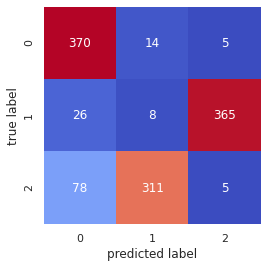

In [0]:
dominant_topics = np.argmax(X_test_plsa, axis=1)

plot_confusion_matrix(test_dataset.target, dominant_topics)
# 100 iterations give the quality 0.8785407989730233
estimate_clustering_quality(test_dataset.target, dominant_topics)

With smoothing (LDA)

In [0]:
lda = PLSA(
    n_topics=3, n_iterations=30,
    alpha_t=0.1/3, alpha_0=0.1, beta_w=0.1/len(trf.vocabulary_), beta_0=0.1
)
X_train_lda = lda.fit_transform(X_train)
X_test_lda = lda.transform(X_test)

In [0]:
show_vectorizer_largest_components(trf, lda.components_)

['gif', 'mail', 'information', 'does', 'space', 'know', 'like', 'program',
 'files', 'ftp', 'images', 'jpeg', 'available', 'file', 'use', 'software',
 'data', 'graphics', 'edu', 'image']
['data', 'program', 'spacecraft', 'people', 'new', 'mission', 'years', 'like',
 'time', 'moon', 'year', 'just', 'shuttle', 'lunar', 'satellite', 'orbit',
 'earth', 'nasa', 'launch', 'space']
['17', 'nhl', '13', '20', '18', 'period', '15', '14', 'games', '16', '25', '12',
 'season', '11', '55', 'play', 'hockey', '10', 'game', 'team']


0.8635129539765979

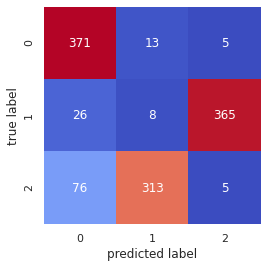

In [0]:
dominant_topics = np.argmax(X_test_lda, axis=1)

plot_confusion_matrix(test_dataset.target, dominant_topics)
# 100 iterations give the quality 0.8821097151600854
estimate_clustering_quality(test_dataset.target, dominant_topics)

<!--@slideshow slide-->
# Colab demo: gensim

`gensim` is a Python library that implements LDA algorithm.

In [0]:
import spacy

# to work with gensim we need to convert data into representable form
# hence we need to tokenize text separately
# extract tokens (lemmas) with spaCy
# we are interested in interpretable topics, so keep only nouns, adjectives, verbs and adverbs
nlp = spacy.load("en", disable=['parser', 'ner'])
def tokens(s):
    return [t.lemma_ for t in nlp(s) if t.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']]

train_documents = [tokens(t) for t in tqdm(train_dataset.data, desc="tokenize")] # list of lists
print(train_documents[0])

NameError: ignored

In [0]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(train_documents) # accepts list of lists

# Filter out words that occur less than in 5 documents, or more than in 50% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.5)
print("dictionary word with index 10:", dictionary[10])

dictionary word with index 10: hardware


In [0]:
# Convert tokenized documents into bag-of-words (BOW) representation: (word index, word count)
corpus = [dictionary.doc2bow(doc) for doc in train_documents]
print("Example of BOW representation:", corpus[0])
print('Number of unique tokens:', len(dictionary))
print('Number of documents:', len(corpus))

Example of BOW representation: [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 3), (7, 1), (8, 3), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1)]
Number of unique tokens: 2730
Number of documents: 1777


In [0]:
from gensim.models import LdaModel

# train LDA model
lda = LdaModel(
    corpus,  # documents in BOW format
    id2word=dictionary.id2token,  # id -> word mapping to make topics interpretable
    num_topics=3,  # desired number of topics
    passes=30,  # number of iterations
)

# recall what true categories are
print("True categories:", train_dataset.target_names)

# look at the topics
print("LDA topics:")
lda.print_topics()

True categories: ['comp.graphics', 'rec.sport.hockey', 'sci.space']
LDA topics:


[(0,
  '0.017*"game" + 0.016*"will" + 0.015*"team" + 0.014*"play" + 0.011*"would" + 0.011*"go" + 0.009*"think" + 0.009*"year" + 0.008*"player" + 0.008*"get"'),
 (1,
  '0.018*"image" + 0.014*"can" + 0.013*"use" + 0.013*"file" + 0.010*"will" + 0.009*"program" + 0.007*"also" + 0.007*"available" + 0.007*"format" + 0.007*"other"'),
 (2,
  '0.012*"space" + 0.010*"will" + 0.009*"launch" + 0.009*"would" + 0.007*"use" + 0.007*"can" + 0.006*"year" + 0.006*"satellite" + 0.006*"orbit" + 0.005*"more"')]

0.778487125279472

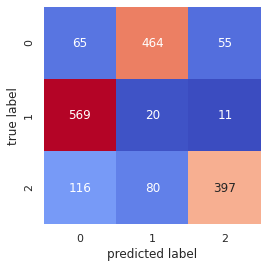

In [0]:
# check that topics provide good clusterization of the training data
def get_topic(lda, doc):
    # helper function for gensim
    return max(lda.get_document_topics(doc), key=lambda t: t[1])[0]

train_topics = [get_topic(lda, doc) for doc in corpus]
plot_confusion_matrix(train_dataset.target, train_topics)
estimate_clustering_quality(train_dataset.target, train_topics)


<!--@slideshow slide-->
# Colab demo: pyLDAvis
Python library for interactive topic model visualization. 

In [0]:
!pip install -q pyldavis
# pyldavis makes gensim spam with warnings, suppress
import warnings
warnings.filterwarnings('ignore')

     |████████████████████████████████| 1.6MB 2.8MB/s 
     |████████████████████████████████| 552kB 17.0MB/s 


In [0]:
# Colab hint: View output fullscreen
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.017470 -0.109132       1        1  33.982433
0     -0.158061  0.044990       2        1  33.181553
1      0.140592  0.064141       3        1  32.836021, topic_info=      Term        Freq        Total Category  logprob  loglift
301   game  653.000000   653.000000  Default  30.0000  30.0000
48   image  727.000000   727.000000  Default  29.0000  29.0000
130   play  560.000000   560.000000  Default  28.0000  28.0000
182   team  602.000000   602.000000  Default  27.0000  27.0000
6     file  499.000000   499.000000  Default  26.0000  26.0000
..     ...         ...          ...      ...      ...      ...
583   work  174.445801   349.966553   Topic3  -5.3829   0.4174
40   would  236.319702  1022.625427   Topic3  -5.0793  -0.3513
68    find  162.657455   310.822662   Topic3  -5.4529   0.4661
268   more  173.899414   588.212036   Topic3  -5.3860  -0.1050
52    look  163.212479   379.462524   Topic3  -5.4495   0.2699

[243 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
132       1  0.837561      %
132       2  0.130191      %
132       3  0.030378      %
253       1  0.360517      -
253       2  0.175752      -
...     ...       ...    ...
126       3  0.856089  write
87        1  0.397647   year
87        2  0.580665   year
87        3  0.021629   year
753       2  0.990481   zone

[397 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

<!--@slideshow slide-->
# Evaluate quality of topics.

Visually, we can evaluate top words (ordered by $\Pr(w|t)$) and decide if they form a meaningful topic.

**Idea**: top words of a topic should often co-occur.

**Definition**: topic coherence is the measure of how often the most "representative" words of a topic occur together.

<!--@slideshow slide-->
## Colab demo: implementation of coherence with PMI

In [0]:
def get_top_topic_words(lda, dictionary, k=10):
    # helper function that returns top k words for each topic
    top_words = dict()
    for topicid in range(lda.num_topics):
        top_words[topicid] = [dictionary[tokenid] for tokenid, _ in lda.get_topic_terms(topicid, k)]
    return top_words

from pprint import pprint
pprint(get_top_topic_words(lda, dictionary, k=10), compact=True)

{0: ['game', 'will', 'team', 'play', 'would', 'go', 'think', 'year', 'player',
     'get'],
 1: ['image', 'can', 'use', 'file', 'will', 'program', 'also', 'available',
     'format', 'other'],
 2: ['space', 'will', 'launch', 'would', 'use', 'can', 'year', 'satellite',
     'orbit', 'more']}


In [0]:
def topic_coherence(documents, topic_words, window_size=10):
    from collections import Counter
    from itertools import combinations
    import numpy as np

    # Step 1. Compute word occurrence and co-occurrence in documents
    words_count = Counter()
    word_pairs_count = Counter()
    num_windows = 0
    for document in documents:
        # count word co-occurrence in a sliding window
        for window_start in range(max(0, len(document) - window_size) + 1):
            num_windows += 1
            window = document[window_start:window_start + window_size]
            for w in window:
                words_count[w] += 1
            for word_pair in combinations(sorted(window), 2):
                assert word_pair[0] <= word_pair[1]
                word_pairs_count[word_pair] += 1

    # Step 2. Estimate how often top words in topics co-occur.
    scores = []
    for topic_word_pair in combinations(sorted(topic_words), 2):
        assert topic_word_pair[0] <= topic_word_pair[1]
        # we can estimate how dependent two words are
        # P(w1, w2) is the probability to find both words close to each other
        P_w1_w2 = word_pairs_count[topic_word_pair] / num_windows
        # P(w1) is the probability to find the first word in a document
        P_w1 = words_count[topic_word_pair[0]] / num_windows
        # P(w2) is the probability to find the second word in a document
        P_w2 = words_count[topic_word_pair[1]] / num_windows

        # if P(w1, w2) == P(w1) * P(w2), then w1 and w2 are independent
        # if P(w1, w2) > P(w1) * P(w2), then w1 and w2 often co-occur

        # compute log(P(w1, w2) / (P(w1) * P(w2))) as a measure of co-occurrence
        # (it is called Pointwise Mutual Information, or PMI)
        score = np.log(P_w1_w2 / (P_w1 * P_w2))
        scores.append(score)
    return np.mean(scores)

for topic, topic_words in get_top_topic_words(lda, dictionary, k=10).items():
    print(topic, topic_coherence(train_documents, topic_words))

0 0.3632820357070297
1 0.3831533479100026
2 -0.0514056433112338


<!--@slideshow slide-->
## Colab quiz 4

Choose the words with highest $PMI$.

In [0]:
np.log((1/4)/(1/8)), np.log((1/16)/(1/8))

(0.6931471805599453, -0.6931471805599453)

In [0]:
enable_mathjax_in_cell()
quiz_coherence()()

<!--@slideshow slide-->
## Colab demo: coherence in gensim

`gensim` implements several versons of coherence, but the idea is always the same: estimate how often top words in topics co-occur.

In [0]:
from gensim.models import CoherenceModel
cm_uci = CoherenceModel(
    model=lda,
    texts=train_documents,
    dictionary=dictionary,
    coherence='c_uci',  # 'c_uci' is similar to our implementation
    topn=10
)
print("'c_uci' coherence per topic:", cm_uci.get_coherence_per_topic())
print("average 'c_uci' coherence:", cm_uci.get_coherence())

'c_uci' coherence per topic: [0.3516373805029231, 0.3762110984123889, -0.03177036536676752]
average 'c_uci' coherence: 0.23202603784951484


In [0]:
# 'c_v' is the current state-of-the-art
# see http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf for details
cm_v = CoherenceModel(
    model=lda,
    texts=train_documents,
    dictionary=dictionary,
    coherence='c_v',
    topn=10
)
print("'c_v' coherence per topic:", cm_v.get_coherence_per_topic())
print("average 'c_v' coherence:", cm_v.get_coherence())

'c_v' coherence per topic: [0.6321687836722216, 0.5221580742011538, 0.4389226872706772]
average 'c_v' coherence: 0.5310831817146843


Using coherence , we can choose the optimal number of topics.

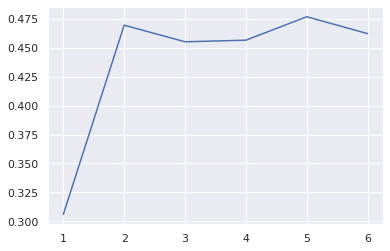

In [0]:
import warnings
warnings.filterwarnings('ignore')

num_topics_grid = list(range(1, 7))
coherences = []
for num_topics in tqdm(num_topics_grid):
    # train LDA with num_topics
    lda_ = LdaModel(corpus, id2word=dictionary.id2token, num_topics=num_topics, passes=5)
    # evaluate coherence
    cm = CoherenceModel(model=lda_, texts=train_documents, dictionary=dictionary, coherence='c_v', topn=10)
    coherences.append(cm.get_coherence())
plt.plot(num_topics_grid, coherences)
plt.show()

<!--@slideshow slide-->
# Colab demo: apply LDA model

In [0]:
# experiment: document containing 1 word "space"
space_doc = dictionary.doc2bow(["space"])
print("document topics:", lda.get_document_topics(space_doc))  # belongs to topic 0
print("term topics:", lda.get_term_topics(space_doc[0][0], minimum_probability=0))

document topics: [(0, 0.6497827), (1, 0.18174338), (2, 0.16847393)]
term topics: [(0, 0.0098694), (1, 0.0044430923), (2, 0.00068774127)]



test document example: ['lose', 'year', 'maybe', 'should', 'eye', 'check', 'team', 'get', 'respect', 'mabee']


0.7222606669904623

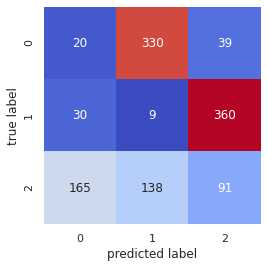

In [0]:
# apply on new data
test_documents = [tokens(t) for t in tqdm(test_dataset.data, desc="tokenize")]
print("test document example:", test_documents[0])
test_corpus = [dictionary.doc2bow(doc) for doc in test_documents]
test_topics = [get_topic(lda, doc) for doc in test_corpus]
plot_confusion_matrix(test_dataset.target, test_topics)
estimate_clustering_quality(test_dataset.target, test_topics)

<!--@slideshow slide-->
# Coding session 3

## Exercise 1

Tokenize the texts. Use the method `tokens()` implemented above.

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv("harbour-space-text-mining-course/datasets/content_classification.csv", header=0, names=["text", "label"])
# YOUR CODE HERE

import spacy

# to work with gensim we need to convert data into representable form
# hence we need to tokenize text separately extract tokens (lemmas) with spaCy
# we are interested in interpretable topics, so keep only nouns, adjectives, verbs and adverbs
nlp = spacy.load("en", disable=['parser', 'ner'])
def tokens(s):
    return [t.lemma_ for t in nlp(s) if t.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']]

le = LabelEncoder()
y = le.fit_transform(df.label)
X_train, X_test, y_test, y_train = train_test_split(df.text, y, test_size=0.25, shuffle=True, random_state=42)
X_train = [tokens(t) for t in tqdm(X_train, desc="tokenize")]
X_train[0]

['receive',
 'email',
 'state',
 'final',
 'piece',
 'client',
 'personal',
 'computer',
 'arrive',
 'tomorrow',
 'pretty',
 'excited',
 'build',
 'see',
 'how',
 'like',
 'final',
 'product']

## Exercise 2

Create the dictionary for Gensim.
- Filter out words that occur less than in 5 documents, or more than in 50% of the documents.
- **NB**. There is a bug in Gensim: the dictionary should be initialized. To initialize the dictionary, you can just access an element of it. So print the dictionary element with the index 10.

In [5]:
from gensim.corpora import Dictionary

# YOUR CODE HERE
dictionary = Dictionary(X_train)
dictionary.filter_extremes(no_below=5, no_above=0.5)
print("dictionary word with index 10:", dictionary[10])

dictionary word with index 10: piece


## Exercise 3

Create the corpus, converting each document from the exercise 1 to the bag-of-words representation using `.doc2bow()` method of the dictionary created in the Exercise 2.

In [6]:
# YOUR CODE HERE
corpus = [dictionary.doc2bow(doc) for doc in X_train]
print("Example of BOW representation:", corpus[0])
print('Number of unique tokens:', len(dictionary))
print('Number of documents:', len(corpus))

Example of BOW representation: [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1)]
Number of unique tokens: 1629
Number of documents: 9497


## Exercise 4

Train `LdaModel` with 7 topics. Use 10 passes over the training data.

In [7]:
from gensim.models import LdaModel

# YOUR CODE HERE
lda = LdaModel(
    corpus,  # documents in BOW format
    id2word=dictionary.id2token,  # id -> word mapping to make topics interpretable
    num_topics=7,  # desired number of topics
    passes=10,  # number of iterations
)

# recall what true categories are
print("True categories:", y_train)

# look at the topics
print("LDA topics:")
lda.print_topics()

True categories: [1 1 1 ... 1 0 2]
LDA topics:


[(0,
  '0.032*"time" + 0.029*"happy" + 0.027*"very" + 0.024*"first" + 0.022*"go" + 0.018*"see" + 0.018*"get" + 0.017*"when" + 0.016*"school" + 0.016*"so"'),
 (1,
  '0.048*"buy" + 0.041*"new" + 0.040*"eat" + 0.040*"dinner" + 0.025*"car" + 0.023*"go" + 0.022*"food" + 0.022*"make" + 0.018*"favorite" + 0.016*"wife"'),
 (2,
  '0.078*"happy" + 0.045*"make" + 0.037*"when" + 0.025*"very" + 0.021*"day" + 0.020*"feel" + 0.019*"month" + 0.018*"last" + 0.017*"so" + 0.014*"love"'),
 (3,
  '0.050*"watch" + 0.049*"go" + 0.026*"time" + 0.024*"movie" + 0.024*"spend" + 0.021*"family" + 0.021*"get" + 0.019*"day" + 0.018*"walk" + 0.017*"show"'),
 (4,
  '0.045*"get" + 0.034*"work" + 0.031*"new" + 0.027*"job" + 0.026*"receive" + 0.017*"money" + 0.017*"good" + 0.017*"find" + 0.014*"start" + 0.013*"pay"'),
 (5,
  '0.110*"friend" + 0.032*"game" + 0.029*"go" + 0.026*"play" + 0.022*"see" + 0.020*"old" + 0.020*"good" + 0.018*"win" + 0.018*"talk" + 0.017*"time"'),
 (6,
  '0.058*"work" + 0.036*"make" + 0.028*"today

## Exercise 5

Visualize the LDA model from the Exercise 4 using `pyLDAVis`.

In [0]:
# YOUR CODE HERE
!pip install -q pyldavis
# pyldavis makes gensim spam with warnings, suppress
import warnings
warnings.filterwarnings('ignore')

In [10]:
# Colab hint: View output fullscreen
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.094742  0.115531       1        1  19.096737
0      0.022291  0.161304       2        1  18.001558
4      0.204371 -0.102136       3        1  14.162217
6      0.181817  0.005235       4        1  13.178513
5     -0.206814  0.103325       5        1  12.961592
3     -0.199906  0.005660       6        1  11.895737
1     -0.096501 -0.288920       7        1  10.703648, topic_info=       Term         Freq        Total Category  logprob  loglift
109  friend  1073.000000  1073.000000  Default  30.0000  30.0000
156    work   977.000000   977.000000  Default  29.0000  29.0000
105   happy  1841.000000  1841.000000  Default  28.0000  28.0000
72    watch   444.000000   444.000000  Default  27.0000  27.0000
160     buy   385.000000   385.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
82    night    65.141724   285.747192   Topic7  -4.8157   0.7560
114   great    65.596794   313.722290   Topic7  -4.8087   0.6696
19      get    87.891861  1424.456543   Topic7  -4.5162  -0.5509
88    house    57.816219   202.647720   Topic7  -4.9350   0.9804
25     home    62.240799   376.549316   Topic7  -4.8613   0.4345

[451 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
116       1  0.158705       able
116       3  0.204049       able
116       4  0.215385       able
116       5  0.119029       able
116       6  0.156815       able
...     ...       ...        ...
412       5  0.036102  yesterday
412       6  0.246694  yesterday
412       7  0.006017  yesterday
588       1  0.830967      young
588       6  0.153883      young

[711 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 5, 7, 6, 4, 2])

## Exercise 6

Choose the best parameters of `LdaModel` using `CoherenceModel`.

You can try different number of topics and more passes.

In [12]:
import warnings
warnings.filterwarnings('ignore')

# YOUR CODE HERE
from gensim.models import CoherenceModel
cm_v = CoherenceModel(
    model=lda,
    texts=X_train,
    dictionary=dictionary,
    coherence='c_v',
    topn=10
)
print("'c_v' coherence per topic:", cm_v.get_coherence_per_topic())
print("average 'c_v' coherence:", cm_v.get_coherence())

'c_v' coherence per topic: [0.5950477621220742, 0.3451495852020402, 0.6640944757943139, 0.42083294858748765, 0.406587569530347, 0.3763819801887743, 0.34072194407727774]
average 'c_v' coherence: 0.44983089507175933


<!--@slideshow slide-->
# Summary
1. We can find groups of related documents using  $k$-means algorithm and TF-IDF vectors.
1. Centroids of clusters are interpretable: words with largest components form _topics_.
1. We can find topics using non-negative matrix factorization (NMF).
1. Probabilistic versions of NMF PLSA and LDA (EM-algorithm).
1. Python libraries: gensim, pyLDAvis.
1. We can evaluate quality of topics using _coherence_: how often "important" words of the topic occur together.

<!--@slideshow slide-->
# Recommended resources
- [📖 "In Depth: k-Means Clustering" by Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html)
- [📖 "Topic Modeling with Gensim (Python)" by Selva Prabhakaran](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)
- [📖 Exploring the Space of Topic Coherence Measures](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf)
- [📖 Topic Models (in Russian)](http://www.machinelearning.ru/wiki/images/f/fb/Voron-ML-TopicModels.pdf)

# [OPTIONAL] Regilarized non-negative factorization

Clearly, there is no unique solution for factorization.
We may start with different initial values and get different results:

In [0]:
W, H = non_negative_number_factorization(4, D0=0.1, W0=10)
print(W, H, W*H)

0.39969104803993377 10.007479605095991 3.9999000115990793


We may want to restrict the number of solutions.

Let's put the additional constraint: $W \approx H$.

This constraint is enforced with *regularization*: instead of minimizing
$$
L_X(W, H) = \frac{1}{2} (X - WH)^2
$$
we will minimize
$$
L_{X, \alpha}(W, H) = \frac{1}{2} (X - WH)^2 + \color{red}{\frac{\alpha}{2} (W^2 + H^2)}
$$

Intuition: we need $W \approx H$, or $(W - H)^2 = W^2 + H^2 - 2WH \approx 0$. Since $WH$ is restricted ($WH \approx X$), we need the remaining part $W^2 + H^2$ to be as small as possible.

Now the derivatives are
- $\dfrac{\mathrm{d}L_{X, \alpha}}{\mathrm{d}H} = (WH-X)W \color{red}{+ \alpha H}$
- $\dfrac{\mathrm{d}L_{X, \alpha}}{\mathrm{d}W} = (WH-X)H \color{red}{+ \alpha W}$


In [0]:
def non_negative_number_factorization_regularized(
    X,  # number to factorize
    H0=None,  # optional initial value for H
    W0=None,  # optional initial value for W
    tolerance=1e-4,  # stop iterations if |X - WH| < tolerance
    max_iterations=100000,  # stop iterations after max_iterations even if |X - WH| > tolerance
    learning_rate=1e-5,  # lambda in the formula
    alpha=0.1,  # regularization factor
    seed=0,
):
    import numpy as np
    # initialize W and H with W0, H0 or randomly
    np.random.seed(seed)
    W = W0 or np.random.random() * X  # random from 0 to X
    H = H0 or np.random.random() * X  # random from 0 to X

    # repeat alternating steps until convergence
    num_iterations = 0
    while np.abs(X - W*H) > tolerance:
        if num_iterations > max_iterations:
            break
        num_iterations += 1
        H_step = -learning_rate * ((W*H - X) * W + alpha * H)
        H += H_step
        assert H > 0
        W_step = -learning_rate * ((W*H - X) * H + alpha * W)
        W += W_step
        assert W > 0
    return W, H

W, H = non_negative_number_factorization_regularized(4, W0=10, H0=0.1, alpha=0.5)
print(W, H, W*H)

6.098554950713719 0.6392946029826294 3.898773265984276


# [OPTIONAL] Math behind `lda.get_document_topics`

This is the illustrative example how to compute probability of topic for a given document: $\Pr(t|d)$.

If $d$ contains only one word $w$, then $\Pr(t|d) = \Pr(t|w)$.

What we have is $\Pr(w|t)$, transform it to $\Pr(t|w)$ using Bayes' rule:
$$
\Pr(t|w) = \dfrac{\Pr(t, w)}{\Pr(w)} = \dfrac{\Pr(w|t)\Pr(t)}{\Pr(w)}
$$
We can estimate $\Pr(t)$ and $\Pr(w)$ summing over all documents.